# Importing Libraries

In [1]:
!apt-get update


Get:1 http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1581 B]
Err:1 http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
  The following signatures couldn't be verified because the public key is not available: NO_PUBKEY A4B469963BF863CC
Ign:2 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:4 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease                        
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]    
Get:7 http://packages.cloud.google.com/apt gcsfuse-bionic InRelease [5004 B]   
Get:8 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Packages [73.8 kB]
Get:9 http://pac

In [2]:
!apt-get install -y libsndfile1

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libflac8 libogg0 libvorbis0a libvorbisenc2
The following NEW packages will be installed:
  libflac8 libogg0 libsndfile1 libvorbis0a libvorbisenc2
0 upgraded, 5 newly installed, 0 to remove and 236 not upgraded.
Need to get 557 kB of archives.
After this operation, 2051 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libogg0 amd64 1.3.2-1 [17.2 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libflac8 amd64 1.3.2-1ubuntu0.1 [213 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libvorbis0a amd64 1.3.5-4.2 [86.4 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/main amd64 libvorbisenc2 amd64 1.3.5-4.2 [70.7 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libsndfile1 amd64 1.0.28-4ubuntu0.18.04.2 [170 kB]
Fetched 557 kB in 3s (189 kB/s)   

In [3]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Using TensorFlow backend.


## 1.Data Preparation

In [4]:
# Paths for data.
#Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

In [5]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

,Emotions,Path
0,happy,/kaggle/input/surrey-audiovisual-expressed-emo...
1,fear,/kaggle/input/surrey-audiovisual-expressed-emo...
2,happy,/kaggle/input/surrey-audiovisual-expressed-emo...
3,disgust,/kaggle/input/surrey-audiovisual-expressed-emo...
4,angry,/kaggle/input/surrey-audiovisual-expressed-emo...


In [6]:
# creating Dataframe using all the 4 dataframes we created so far.
#data_path = pd.concat([Savee_df,Tess_df], axis = 0)
data_path = Savee_df
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,happy,/kaggle/input/surrey-audiovisual-expressed-emo...
1,fear,/kaggle/input/surrey-audiovisual-expressed-emo...
2,happy,/kaggle/input/surrey-audiovisual-expressed-emo...
3,disgust,/kaggle/input/surrey-audiovisual-expressed-emo...
4,angry,/kaggle/input/surrey-audiovisual-expressed-emo...


## 2.Data Visualisation and Exploration

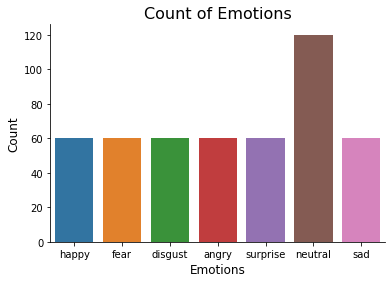

In [7]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [8]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

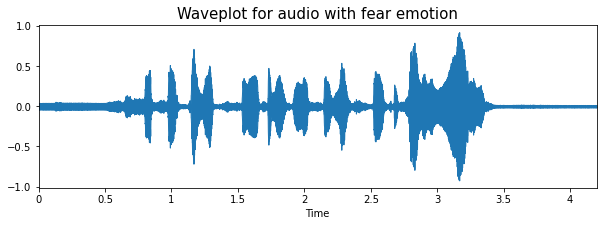

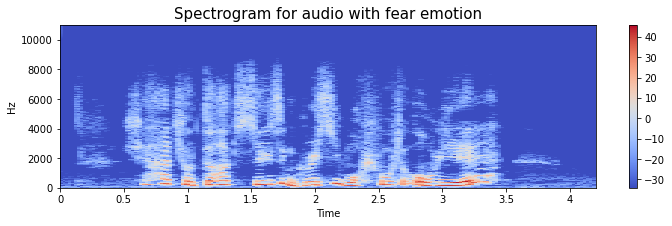

In [9]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

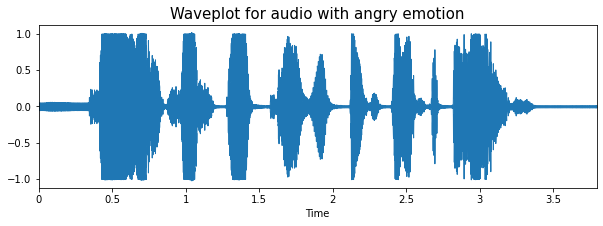

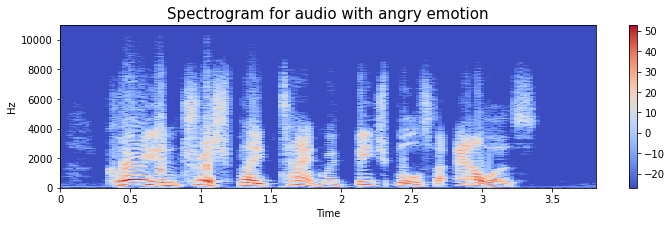

In [10]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

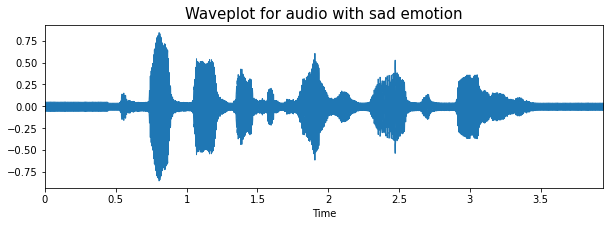

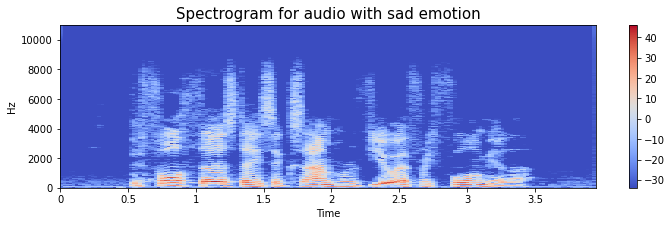

In [11]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

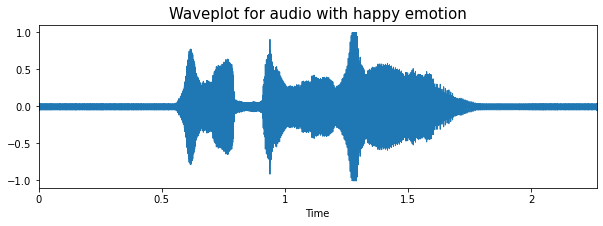

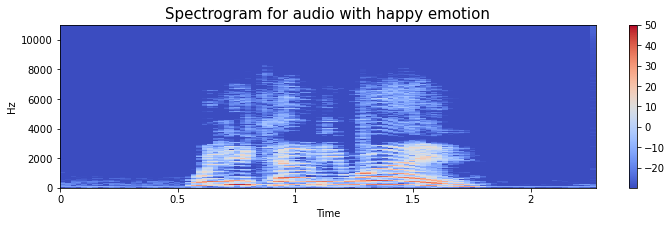

In [12]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## 3.Data Augmentation

In [13]:
#data augmentation

def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

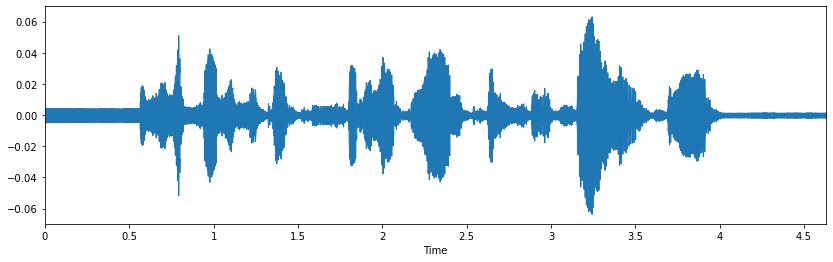

In [14]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

#### 2. Noise Injection

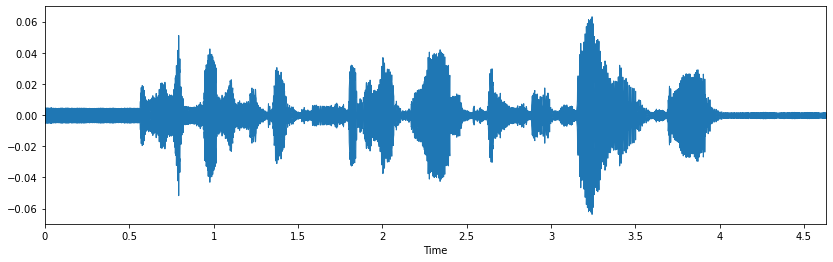

In [15]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

#### 3. Stretching

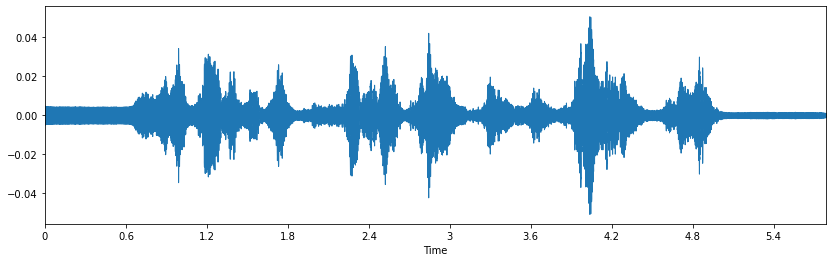

In [16]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4. Shifting

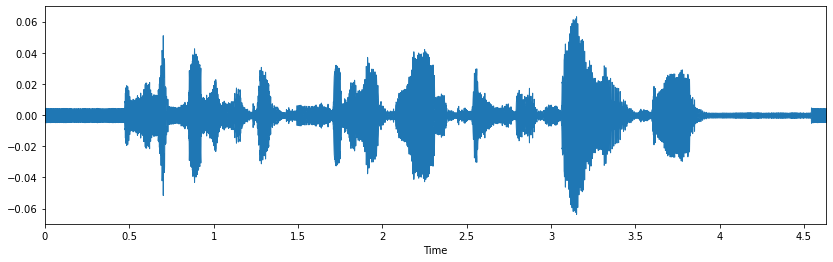

In [17]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5. Pitch

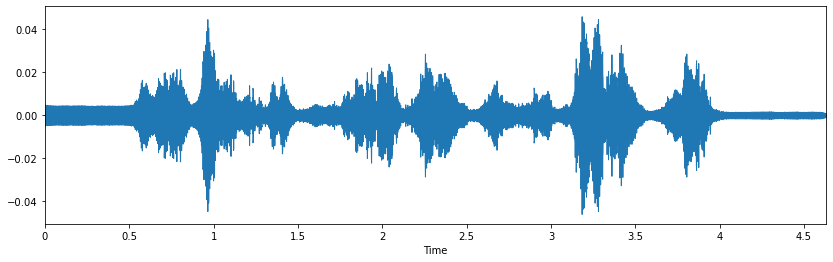

In [18]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

- From the above types of augmentation techniques i am using noise, stretching(ie. changing speed) and some pitching.

## Feature Extraction

In [19]:
#feature extraction
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally
   # print("zcr=",result)

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally
   # print("chr=",result)

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally
    #print("mfcc=",result)

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally
    #print("Rms=",result)

    # MelSpectogram
    #mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    #result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [20]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [21]:
feature.shape

(3, 34)

In [22]:
len(X), len(Y), data_path.Path.shape

(1440, 1440, (480,))

In [23]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,labels
0,0.036576,0.595905,0.516783,0.464622,0.383405,0.405006,0.426545,0.439624,0.407500,0.355450,...,-0.500308,-10.475996,4.101040,-3.050556,-8.308379,-0.714005,-11.109069,-9.154726,0.190734,happy
1,0.076601,0.650993,0.584053,0.545263,0.464911,0.468247,0.448249,0.452391,0.431128,0.408080,...,-4.320138,-3.794185,-0.039528,-1.998648,-5.486334,-4.272503,-7.785460,-6.808529,0.191503,happy
2,0.040245,0.563645,0.631917,0.528007,0.485068,0.403470,0.398644,0.436642,0.478029,0.436602,...,-2.024024,-8.924806,6.132502,-6.210916,-7.317426,-3.783760,-13.574641,-4.624477,0.087803,happy
3,0.047323,0.533989,0.533688,0.547161,0.468844,0.467730,0.529523,0.519883,0.514486,0.549118,...,-1.571896,0.615496,-1.969707,4.323563,3.184680,-3.817714,5.742719,6.466970,0.007461,fear
4,0.049782,0.535622,0.548458,0.560728,0.538504,0.471032,0.512098,0.530213,0.517432,0.522945,...,-1.566482,0.410660,-1.019256,2.601613,2.534859,-0.529410,4.277052,4.271310,0.007463,fear


In [24]:
#data preparation
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values


In [25]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()


In [26]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape


((1080, 34), (1080, 7), (360, 34), (360, 7))

In [27]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1080, 34), (1080, 7), (360, 34), (360, 7))

In [28]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1080, 34, 1), (1080, 7), (360, 34, 1), (360, 7))

## Modelling

In [29]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=7, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 34, 256)           1536      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 17, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 17, 256)           327936    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 9, 256)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 9, 128)            163968    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 128)           

In [30]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=200, validation_data=(x_test, y_test), callbacks=[rlrp])

Train on 1080 samples, validate on 360 samples
Epoch 1/200
1080/1080 [==============================] - 3s 3ms/step - loss: 1.9007 - accuracy: 0.2194 - val_loss: 1.8207 - val_accuracy: 0.2944
Epoch 2/200
1080/1080 [==============================] - 0s 110us/step - loss: 1.7980 - accuracy: 0.2954 - val_loss: 1.7262 - val_accuracy: 0.3056
Epoch 3/200
1080/1080 [==============================] - 0s 118us/step - loss: 1.7257 - accuracy: 0.3157 - val_loss: 1.6825 - val_accuracy: 0.3500
Epoch 4/200
1080/1080 [==============================] - 0s 108us/step - loss: 1.6710 - accuracy: 0.3324 - val_loss: 1.6104 - val_accuracy: 0.3278
Epoch 5/200
1080/1080 [==============================] - 0s 107us/step - loss: 1.6749 - accuracy: 0.3370 - val_loss: 1.6677 - val_accuracy: 0.3111
Epoch 6/200
1080/1080 [==============================] - 0s 108us/step - loss: 1.6096 - accuracy: 0.3528 - val_loss: 1.5613 - val_accuracy: 0.3806
Epoch 7/200
1080/1080 [==============================] - 0s 107us/step - 

360/360 [==============================] - 0s 171us/step
Accuracy of our model on test data :  71.66666388511658 %
1080/1080 [==============================] - 0s 92us/step
Accuracy of our model on train data :  100.0 %


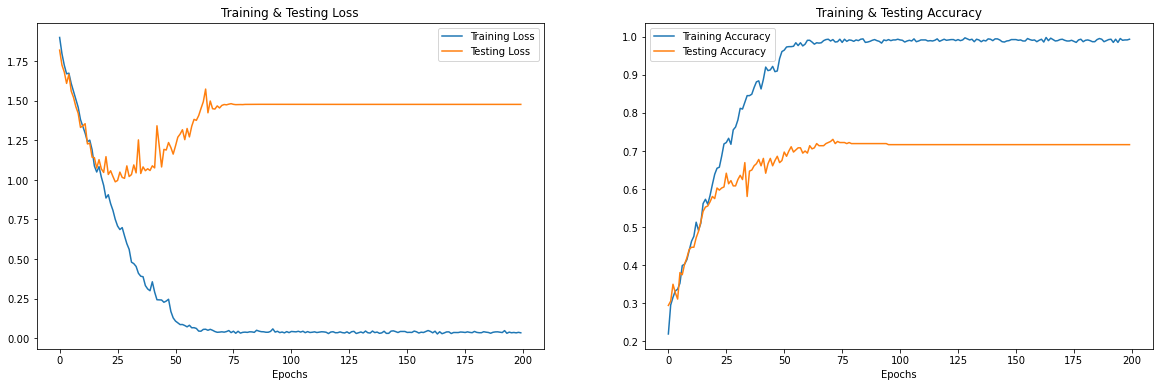

In [31]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")
print("Accuracy of our model on train data : " , model.evaluate(x_train,y_train)[1]*100 , "%")

epochs = [i for i in range(200)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [32]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

## Output

In [33]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,neutral,neutral
1,neutral,neutral
2,neutral,neutral
3,fear,fear
4,surprise,surprise
5,surprise,surprise
6,happy,angry
7,surprise,surprise
8,happy,angry
9,surprise,surprise


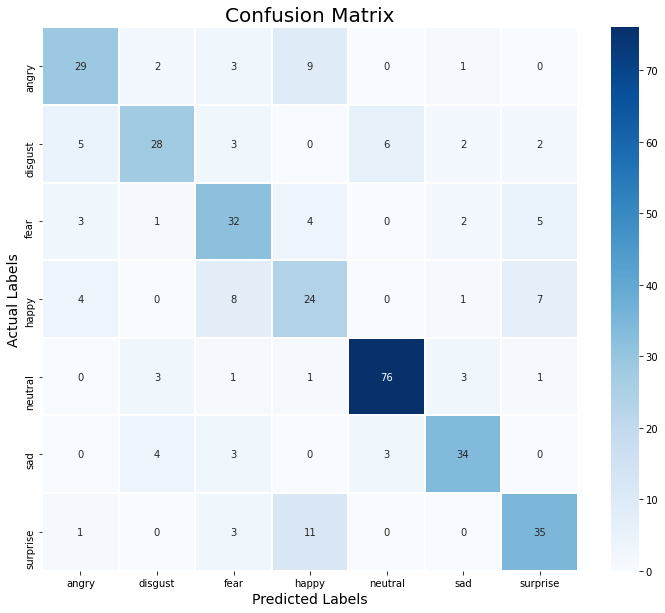

In [34]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.69      0.66      0.67        44
     disgust       0.74      0.61      0.67        46
        fear       0.60      0.68      0.64        47
       happy       0.49      0.55      0.52        44
     neutral       0.89      0.89      0.89        85
         sad       0.79      0.77      0.78        44
    surprise       0.70      0.70      0.70        50

    accuracy                           0.72       360
   macro avg       0.70      0.69      0.70       360
weighted avg       0.72      0.72      0.72       360



In [36]:
import pickle
# Writing different model files to file
with open( 'modelForPrediction1.sav', 'wb') as f:
    pickle.dump(model,f)

In [39]:
filename = 'modelForPrediction1.sav'
loaded_model = pickle.load(open(filename, 'rb')) # loading the model file from the storage
f=get_features("/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/DC_a01.wav")
f = scaler.fit_transform(f)
f= np.expand_dims(f, axis=2)
p_test =loaded_model.predict(f)
samp= encoder.inverse_transform(p_test)
samp.flatten()[0]


'angry'